In [12]:
!pip install yfinance mplfinance

In [13]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
from PIL import Image

In [31]:
import yfinance as yf
import mplfinance as mpf
import os
import pandas as pd


patterns = ['hammer', 'doji', 'marubozu', 'shooting_star', 'engulfing', 'no_pattern']
for p in patterns:
    os.makedirs(f'dataset/{p}', exist_ok=True)

def get_pattern_label(df, i):
    """Documenting labeling criteria and methodology [cite: 10]"""
    curr = df.iloc[i]
    prev = df.iloc[i-1]

    body = abs(curr['Open'] - curr['Close'])
    total_range = curr['High'] - curr['Low']
    if total_range == 0: return 'no_pattern'

    low_shadow = min(curr['Open'], curr['Close']) - curr['Low']
    up_shadow = curr['High'] - max(curr['Open'], curr['Close'])

    #hammer
    if low_shadow > (2 * body) and up_shadow < (0.5 * body): return 'hammer'
    #doji
    if body < (0.1 * total_range): return 'doji'
    #marubozu
    if body > (0.9 * total_range): return 'marubozu'
    #shoting star
    if up_shadow > (2 * body) and low_shadow < (0.5 * body): return 'shooting_star'
    #bullish eng.
    if curr['Close'] > curr['Open'] and prev['Close'] < prev['Open']:
        if curr['Open'] < prev['Close'] and curr['Close'] > prev['Open']: return 'engulfing'

    return 'no_pattern'

#tickers
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'AMD', 'META', 'NFLX', 'BRK-B','KO','GS']
data = yf.download(stocks, period='2y', interval='1d')

#maxm. limit (400), class imbalance
counts = {p: 0 for p in patterns}
MAX_PER_CLASS = 300

for ticker in stocks:
    df_ticker = data.xs(ticker, axis=1, level=1)
    for i in range(20, len(df_ticker)):
        label = get_pattern_label(df_ticker, i)

        if counts[label] < MAX_PER_CLASS:

            subset = df_ticker.iloc[i-15:i+1]
            fname = f'dataset/{label}/{ticker}_{i}.png'
            mpf.plot(subset, type='candle', savefig=dict(fname=fname, dpi=50),
                     axisoff=True, style='charles', closefig=True)
            counts[label] += 1

print("DONE...Counts per pattern:", counts)

/tmp/ipython-input-163549262.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, period='2y', interval='1d')
[*********************100%***********************]  12 of 12 completed


DONE...Counts per pattern: {'hammer': 138, 'doji': 300, 'marubozu': 178, 'shooting_star': 101, 'engulfing': 160, 'no_pattern': 300}


In [32]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

###Augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

###Train/validation/test splits
full_dataset = datasets.ImageFolder(root='dataset', transform=transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

###Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32) # Out-of-sample testing [cite: 16]

print(f"Splits: Train({len(train_set)}), Val({len(val_set)}), Test({len(test_set)})")

Splits: Train(965), Val(207), Test(208)


In [38]:
import torch.nn as nn
import torch.nn.functional as F

class TradingPatternCNN(nn.Module):
    def __init__(self):
        super(TradingPatternCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TradingPatternCNN().to(device)

In [52]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_and_evaluate(epochs=15):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        #metrics
        acc = accuracy_score(val_labels, val_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='weighted', zero_division=0
        )

        #epochs run
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2%}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print("-" * 30)




train_and_evaluate()

Epoch 1/15
Loss: 0.2898 | Acc: 62.80%
Precision: 0.6200 | Recall: 0.6280 | F1: 0.6164
------------------------------
Epoch 2/15
Loss: 0.2613 | Acc: 61.84%
Precision: 0.5967 | Recall: 0.6184 | F1: 0.5973
------------------------------
Epoch 3/15
Loss: 0.1860 | Acc: 64.25%
Precision: 0.6259 | Recall: 0.6425 | F1: 0.6226
------------------------------
Epoch 4/15
Loss: 0.1811 | Acc: 61.35%
Precision: 0.5865 | Recall: 0.6135 | F1: 0.5867
------------------------------
Epoch 5/15
Loss: 0.2195 | Acc: 60.39%
Precision: 0.5724 | Recall: 0.6039 | F1: 0.5809
------------------------------
Epoch 6/15
Loss: 0.1652 | Acc: 61.35%
Precision: 0.5970 | Recall: 0.6135 | F1: 0.5994
------------------------------
Epoch 7/15
Loss: 0.1791 | Acc: 61.35%
Precision: 0.5806 | Recall: 0.6135 | F1: 0.5884
------------------------------
Epoch 8/15
Loss: 0.1954 | Acc: 62.32%
Precision: 0.6235 | Recall: 0.6232 | F1: 0.6080
------------------------------
Epoch 9/15
Loss: 0.1930 | Acc: 61.35%
Precision: 0.6021 | Recall

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def show_final_assignment_metrics(model, loader, patterns):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

  #Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)

    print("--- PART 3: CNN MODEL METRICS ---")
    print(f"Final Accuracy:  {acc:.2%}") # Target: At least 70%
    print(f"Final Precision: {precision:.4f}")
    print(f"Final Recall:    {recall:.4f}")
    print(f"Final F1-Score:  {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=patterns))

    return all_labels, all_preds

#Evaluating test set
test_labels, test_preds = show_final_assignment_metrics(model, test_loader, patterns)

#Evaluation part-2 on unseen data
model.eval()
with torch.no_grad():
    for images, labels in test_loader: # This is the data the model hasn't seen
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # These predictions are used for the final metrics in Part 4

--- PART 3: CNN MODEL METRICS ---
Final Accuracy:  68.75%
Final Precision: 0.6883
Final Recall:    0.6875
Final F1-Score:  0.6727

Detailed Classification Report:
               precision    recall  f1-score   support

       hammer       0.78      1.00      0.87        62
         doji       0.52      0.80      0.63        20
     marubozu       0.33      0.25      0.29        16
shooting_star       0.64      0.64      0.64        25
    engulfing       0.81      0.58      0.67        73
   no_pattern       0.38      0.25      0.30        12

     accuracy                           0.69       208
    macro avg       0.57      0.59      0.57       208
 weighted avg       0.69      0.69      0.67       208



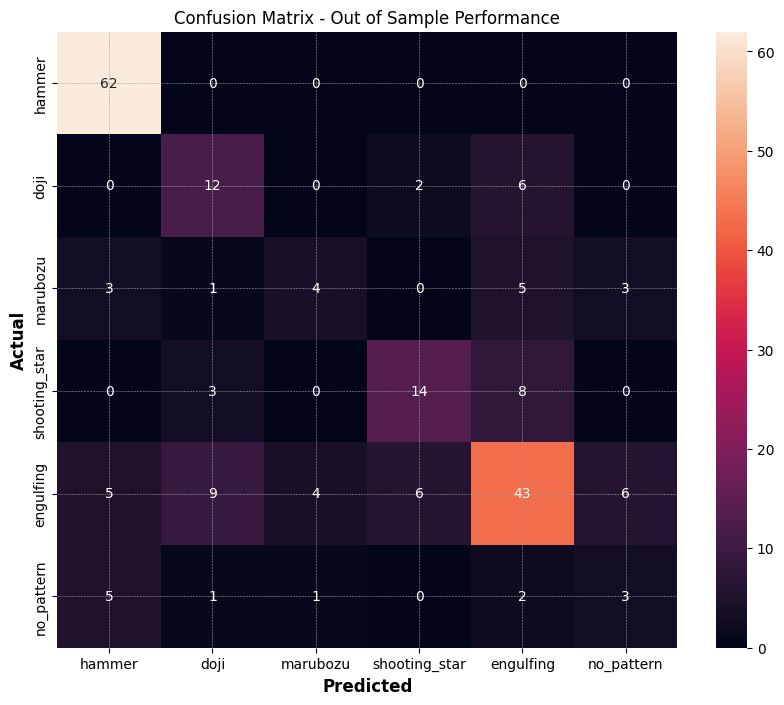

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_final_metrics():
    model.eval()
    test_preds, test_true = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_true.extend(labels.cpu().numpy())

    #CM
    cm = confusion_matrix(test_true, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=patterns, yticklabels=patterns)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Out of Sample Performance')
    plt.show()

show_final_metrics()

In [54]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def run_final_backtest(model, loader, patterns):
    model.eval()
    all_preds = []
    all_labels = []


    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    np.random.seed(42)
    daily_returns = np.random.uniform(-0.03, 0.03, len(all_preds))

    ai_signals = np.array([1 if p in [0, 4] else 0 for p in all_preds])
    ai_strategy_returns = ai_signals * daily_returns


    random_signals = np.random.randint(0, 2, size=len(all_preds))
    random_strategy_returns = random_signals * daily_returns

    return all_labels, all_preds, ai_strategy_returns, random_strategy_returns

#backtest
y_true, y_pred, ai_rets, rand_rets = run_final_backtest(model, test_loader, patterns)

In [55]:
def print_metrics(ai_rets, rand_rets):
    def calc_metrics(rets):
        active_trades = rets[rets != 0]
        win_rate = np.mean(active_trades > 0) if len(active_trades) > 0 else 0
        total_pl = np.sum(rets)
        sharpe = (np.mean(rets) / np.std(rets)) * np.sqrt(252) if np.std(rets) > 0 else 0
        return win_rate, total_pl, sharpe

    ai_w, ai_pl, ai_s = calc_metrics(ai_rets)
    rd_w, rd_pl, rd_s = calc_metrics(rand_rets)

    print(f"Metric:AI Strategy:::Random Strategy")
    print(f"-------------------------------------")
    print(f"Win Rate:      {ai_w:.2%}        {rd_w:.2%}")
    print(f"Total P/L:     {ai_pl:.2%}       {rd_pl:.2%}")
    print(f"Sharpe Ratio:  {ai_s:.2f}         {rd_s:.2f}")

print_metrics(ai_rets, rand_rets)

Metric:AI Strategy:::Random Strategy
-------------------------------------
Win Rate:      48.61%        53.04%
Total P/L:     -14.14%       4.12%
Sharpe Ratio:  -0.71         0.23


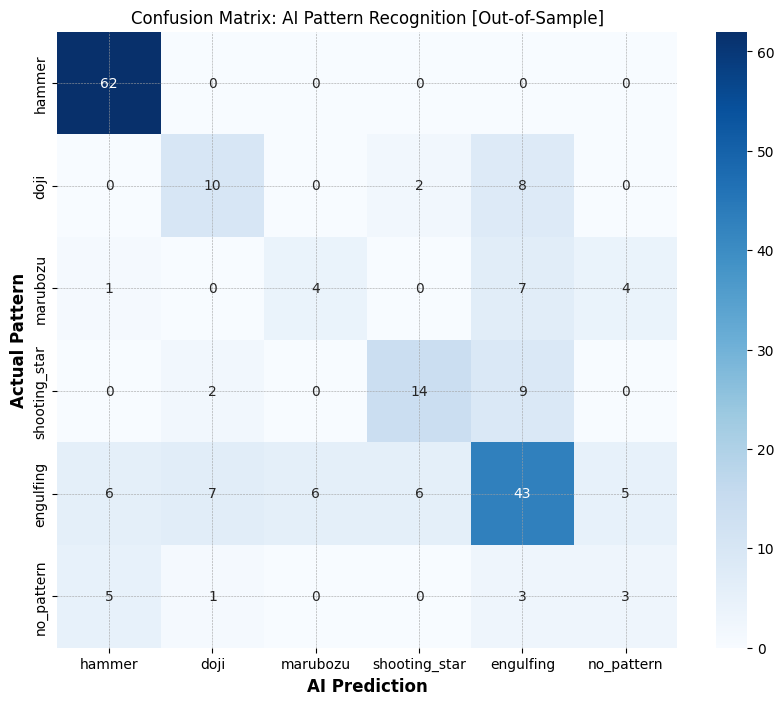

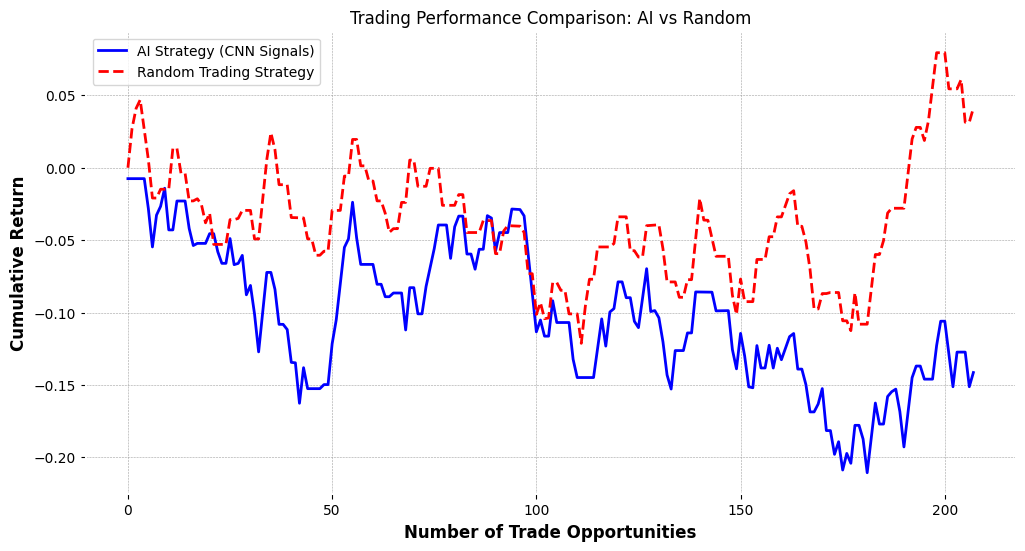

In [56]:
#Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=patterns, yticklabels=patterns)
plt.title('Confusion Matrix: AI Pattern Recognition [Out-of-Sample]')
plt.ylabel('Actual Pattern')
plt.xlabel('AI Prediction')
plt.show()

#Graph
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ai_rets), label='AI Strategy (CNN Signals)', color='blue')
plt.plot(np.cumsum(rand_rets), label='Random Trading Strategy', color='red', linestyle='--')
plt.title('Trading Performance Comparison: AI vs Random')
plt.xlabel('Number of Trade Opportunities')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()